# Автоэнкодеры

**Автоэнкодеры** — это нейронные сети, которые восстанавливают свои же входные данные на выходе. Такой тип обучения называют self-supervised. Внутри у них имеется скрытый слой, который представляет собой код, очень сжато описывающий данные. Автоэнкодеры как правило не имеют возможности точно скопировать вход на выходе. Сеть сильно ограничена в размере кода, и поэтому она вынуждена отбирать наиболее важные признаки, которые часто имеют полезные применения.

![ae](https://habrastorage.org/web/cf6/228/613/cf6228613fdc4f8fb819cbd41bb677eb.png)

# PCA

**PCA** — не просто метод визуализации. Его можно рассматривать как очень простой линейный автоэнкодер. Он состоит всего из двух слоев: матрица-энкодер и матрица-декодер, даже без промежуточных активаций. Это можно решать аналитически (вам, возможно, объяснят на курсе линейной алгебры в ВУЗе), а можно просто градиентным спуском.

In [16]:
from keras.datasets import mnist
import numpy as np

(X, y), _ = mnist.load_data()

X = X.astype('float32') / 255.
X = np.reshape(X, (-1, 784))

Чтобы сделать только автоэнкодер, нам достаточно чего-то типа `PCA = Sequential([Dense, Dense])`, но мы хотим иметь ещё и декодер с энкодером, поэтому нужно немного извернуться. 

In [46]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model, Sequential

source = Input(shape=(784,))
hidden = Dense(2, input_dim=784, use_bias=False)(source)
reconstructed = Dense(784, use_bias=False)(hidden)

PCA = Model(source, reconstructed)

Encoder = Model(source, hidden)

# Keras запрещает использовать что-либо кроме Input, поэтому нужно сделать ещё один
decoder_input = Input(shape=(2,))
Decoder = Model(decoder_input, PCA.layers[-1](decoder_input))

PCA.compile(optimizer='adam', loss='mse')
PCA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 1568      
_________________________________________________________________
dense_46 (Dense)             (None, 784)               1568      
Total params: 3,136
Trainable params: 3,136
Non-trainable params: 0
_________________________________________________________________


In [47]:
PCA.fit(X, X, validation_split=0.1, epochs=1)
#          ^y=X

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 6s - loss: 0.0604 - val_loss: 0.0580


Убедимся, что оно выдает какие-нибудь адекватные кластеры.

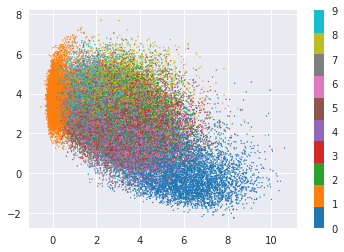

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

t = Encoder.predict(X)

plt.set_cmap('tab10')
plt.scatter(t[:, 0], t[:, 1], c=y, s=1)
plt.colorbar()
plt.show()

# Морфинг

Помимо визуализации, ещё одно применение автоэнкодеров — морфинг (интерполяция) и генерация изображений.

Напишем процедуру, которая будет делать морфинг, имея внешний энкодер и декодер. Не спрашивайте, как это работает.

In [151]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

def imshow(img):
    pic = img.reshape((28, 28))
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(samples, steps, delay, Encoder, Decoder):
    inputs = X[np.random.randint(0, 1000, samples)]
    states = Encoder.predict(inputs)
    fig = plt.figure()
    images = []
    for a, b in zip(states, np.vstack([states[1:], [states[0]]])):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            images.append([imshow(Decoder.predict(c.reshape(1, -1)))])
    ani = ArtistAnimation(fig, images, interval=delay)
    display(HTML(ani.to_html5_video()))

Соберем чуть более сложную нелинейную архитектуру.

In [102]:
Encoder = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu')
])

Decoder = Sequential([
    Dense(64, activation='relu', input_shape=(32,)),
    Dense(128, activation='relu'),
    Dense(784, activation='sigmoid') # пиксели от 0 до 1 — можно пихнуть всё в sigmoid
])

source = Input((784,))
hidden = Encoder(source)
reconstructed = Decoder(hidden)

Autoencoder = Model(source, reconstructed)
Autoencoder.compile(optimizer='adam', loss='mse')
#                                      ^ тут можно попробовать энтропию
Autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 784)               0         
_________________________________________________________________
sequential_20 (Sequential)   (None, 32)                110816    
_________________________________________________________________
sequential_21 (Sequential)   (None, 784)               111568    
Total params: 222,384
Trainable params: 222,384
Non-trainable params: 0
_________________________________________________________________


Автоэнкодер теперь сложный, функция потерь невыпуклая и обучаться до достаточного уровня он будет долго.

In [152]:
Autoencoder.fit(X, X, validation_split=0.1, epochs=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 12s - loss: 0.0141 - val_loss: 0.0132


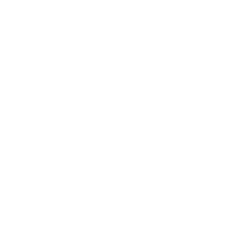

In [155]:
morph(10, 25, 25, Encoder, Decoder)

# Колоризация

Как устроены цветные картинки? Это просто матрица (3 x n x m), в которой каждая первая координата отвечает за свой канал (красный, зелёный и синий).

In [163]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 1836s  
